In [ ]:
# import tensorflow as tf

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

2023-11-30 02:22:46.934926: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 02:22:46.958871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 02:22:46.958895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 02:22:46.958933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 02:22:46.964273: I tensorflow/core/platform/cpu_feature_g

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10344022061522209962
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1807745024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10114186471676203
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2023-11-30 02:22:48.117889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:48.122413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:48.122433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:49.485777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 02:22:49.485814: I tensorflow/compile

In [2]:
# os.chdir("/mnt/")
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/Annaantonin/Data.git

In [ ]:
rm -rf Data

In [ ]:
import Data as data
# data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [ ]:
os.listdir(".")

In [133]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sin_force_noise.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train, t_train.T, x_train, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x, f, log_c, log_k):
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constraints for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)     #velocity                                                                                                                                                                                                                   
    # x_tt = tf.gradients(x_t, t) [0]
    m=5 
    x_tt=(f-tf.exp(log_c) * x_t - tf.exp(log_k) * x)/m
    # f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # return [f,x_tt]
    return x_tt

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)                                                                                                                                                                                                               
    x_tt = tf.gradients(x_t, t) 
    
    return x_tt
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
  
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)),# displacement
    
    )
    process_f = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),  #, activation=tf.sigmoid
        posterior=neuq_vars.fnn.Trainable( layers=layers), #, regularizer=tf.keras.regularizers.l2(1e-5)
    )
    
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=30, num_iterations=10000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # posterior = neuq_vars.pfnn.Trainable(
    #     layers=layers, num=10, regularizer=tf.keras.regularizers.l2(1e-5),
    # )
    
    # method = neuq.inferences.DEns(
    #     num_iterations=10000,
    #     optimizer=tf.train.AdamOptimizer(1e-3),
    #     is_parallelized=True,
    # )
    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x, process_f, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_f, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x, process_f, process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 20, 20, 1]
    # layers_force = [1, 20, 20, 1]
    processes, samples, model = Trainable(
        x_tt_train, t_train, x_train, f_train, noise, layers, 
    )


    x_pred, f_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
    (xtt_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)


2023-11-30 16:02:16.082782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 16:02:16.082867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 16:02:16.082879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 16:02:16.083263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 16:02:16.083288: I tensorflow/core/co

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...


2023-11-30 16:02:17.252478: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_399/Assign' id:25967 op device:{requested: '', assigned: ''} def:{{{node Variable_399/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_399, Const_711)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.909847
Iteration:  1000 , loss:  0.6773857
Iteration:  2000 , loss:  0.5506083
Iteration:  3000 , loss:  0.46248096
Iteration:  4000 , loss:  0.28569806
Iteration:  5000 , loss:  0.25495481
Iteration:  6000 , loss:  0.23498443
Iteration:  7000 , loss:  0.22387971
Iteration:  8000 , loss:  0.21322143
Iteration:  9000 , loss:  0.20267634
Generating 1th sample by deep ensemble...


2023-11-30 16:02:35.389224: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.865355
Iteration:  1000 , loss:  0.7051385
Iteration:  2000 , loss:  0.5427996
Iteration:  3000 , loss:  0.3092878
Iteration:  4000 , loss:  0.25973096
Iteration:  5000 , loss:  0.24385126
Iteration:  6000 , loss:  0.23301105
Iteration:  7000 , loss:  0.22523397
Iteration:  8000 , loss:  0.2188314
Iteration:  9000 , loss:  0.21285383
Generating 2th sample by deep ensemble...


2023-11-30 16:02:53.207312: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8152447
Iteration:  1000 , loss:  0.66598177
Iteration:  2000 , loss:  0.50730556
Iteration:  3000 , loss:  0.30408788
Iteration:  4000 , loss:  0.25863892
Iteration:  5000 , loss:  0.24650145
Iteration:  6000 , loss:  0.23770939
Iteration:  7000 , loss:  0.22882213
Iteration:  8000 , loss:  0.22066249
Iteration:  9000 , loss:  0.21393381
Generating 3th sample by deep ensemble...


2023-11-30 16:03:10.250518: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8322744
Iteration:  1000 , loss:  0.65574074
Iteration:  2000 , loss:  0.43223074
Iteration:  3000 , loss:  0.31336978
Iteration:  4000 , loss:  0.25942248
Iteration:  5000 , loss:  0.23902316
Iteration:  6000 , loss:  0.22293705
Iteration:  7000 , loss:  0.21242066
Iteration:  8000 , loss:  0.19622009
Iteration:  9000 , loss:  0.18717565
Generating 4th sample by deep ensemble...


2023-11-30 16:03:27.012673: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.062815
Iteration:  1000 , loss:  0.7639667
Iteration:  2000 , loss:  0.530663
Iteration:  3000 , loss:  0.32506502
Iteration:  4000 , loss:  0.2748212
Iteration:  5000 , loss:  0.2532468
Iteration:  6000 , loss:  0.23816471
Iteration:  7000 , loss:  0.22798423
Iteration:  8000 , loss:  0.21840426
Iteration:  9000 , loss:  0.20889875
Generating 5th sample by deep ensemble...


2023-11-30 16:03:43.303909: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.839213
Iteration:  1000 , loss:  0.67729497
Iteration:  2000 , loss:  0.4687703
Iteration:  3000 , loss:  0.30624074
Iteration:  4000 , loss:  0.26572898
Iteration:  5000 , loss:  0.24926725
Iteration:  6000 , loss:  0.23909013
Iteration:  7000 , loss:  0.2267926
Iteration:  8000 , loss:  0.21811824
Iteration:  9000 , loss:  0.21093358
Generating 6th sample by deep ensemble...


2023-11-30 16:03:59.938056: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8415747
Iteration:  1000 , loss:  0.7089662
Iteration:  2000 , loss:  0.56651574
Iteration:  3000 , loss:  0.36176902
Iteration:  4000 , loss:  0.30765256
Iteration:  5000 , loss:  0.27594033
Iteration:  6000 , loss:  0.26277924
Iteration:  7000 , loss:  0.25370696
Iteration:  8000 , loss:  0.24039322
Iteration:  9000 , loss:  0.2106927
Generating 7th sample by deep ensemble...


2023-11-30 16:04:16.813354: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.847133
Iteration:  1000 , loss:  0.72890544
Iteration:  2000 , loss:  0.45351425
Iteration:  3000 , loss:  0.31081763
Iteration:  4000 , loss:  0.2811547
Iteration:  5000 , loss:  0.26897848
Iteration:  6000 , loss:  0.2526446
Iteration:  7000 , loss:  0.23749213
Iteration:  8000 , loss:  0.22032063
Iteration:  9000 , loss:  0.1787312
Generating 8th sample by deep ensemble...


2023-11-30 16:04:38.618259: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.002461
Iteration:  1000 , loss:  0.6514486
Iteration:  2000 , loss:  0.43769372
Iteration:  3000 , loss:  0.30763468
Iteration:  4000 , loss:  0.2678709
Iteration:  5000 , loss:  0.25432292
Iteration:  6000 , loss:  0.24424525
Iteration:  7000 , loss:  0.234957
Iteration:  8000 , loss:  0.22368248
Iteration:  9000 , loss:  0.21206462
Generating 9th sample by deep ensemble...


2023-11-30 16:04:55.250929: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8335266
Iteration:  1000 , loss:  0.67941934
Iteration:  2000 , loss:  0.51652986
Iteration:  3000 , loss:  0.33239266
Iteration:  4000 , loss:  0.28572085
Iteration:  5000 , loss:  0.25957862
Iteration:  6000 , loss:  0.24781178
Iteration:  7000 , loss:  0.23780969
Iteration:  8000 , loss:  0.22861858
Iteration:  9000 , loss:  0.21991879
Generating 10th sample by deep ensemble...


2023-11-30 16:05:11.709314: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8365464
Iteration:  1000 , loss:  0.6787557
Iteration:  2000 , loss:  0.37738115
Iteration:  3000 , loss:  0.29151264
Iteration:  4000 , loss:  0.26329246
Iteration:  5000 , loss:  0.24485226
Iteration:  6000 , loss:  0.23234278
Iteration:  7000 , loss:  0.2161287
Iteration:  8000 , loss:  0.1827257
Iteration:  9000 , loss:  0.16467167
Generating 11th sample by deep ensemble...


2023-11-30 16:05:30.647338: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.835215
Iteration:  1000 , loss:  0.7201119
Iteration:  2000 , loss:  0.42674834
Iteration:  3000 , loss:  0.2909233
Iteration:  4000 , loss:  0.25657478
Iteration:  5000 , loss:  0.2408518
Iteration:  6000 , loss:  0.22818325
Iteration:  7000 , loss:  0.21360955
Iteration:  8000 , loss:  0.18638313
Iteration:  9000 , loss:  0.17667031
Generating 12th sample by deep ensemble...


2023-11-30 16:05:48.528800: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8314567
Iteration:  1000 , loss:  0.66162425
Iteration:  2000 , loss:  0.52915937
Iteration:  3000 , loss:  0.31271073
Iteration:  4000 , loss:  0.27032793
Iteration:  5000 , loss:  0.25414374
Iteration:  6000 , loss:  0.24150561
Iteration:  7000 , loss:  0.2274851
Iteration:  8000 , loss:  0.2135428
Iteration:  9000 , loss:  0.19482392
Generating 13th sample by deep ensemble...


2023-11-30 16:06:05.856397: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.013369
Iteration:  1000 , loss:  0.72611576
Iteration:  2000 , loss:  0.3702198
Iteration:  3000 , loss:  0.29381046
Iteration:  4000 , loss:  0.2738107
Iteration:  5000 , loss:  0.26050937
Iteration:  6000 , loss:  0.2423522
Iteration:  7000 , loss:  0.22894299
Iteration:  8000 , loss:  0.20916754
Iteration:  9000 , loss:  0.16836338
Generating 14th sample by deep ensemble...


2023-11-30 16:06:23.564416: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.937391
Iteration:  1000 , loss:  0.68600386
Iteration:  2000 , loss:  0.49377733
Iteration:  3000 , loss:  0.30532077
Iteration:  4000 , loss:  0.2635293
Iteration:  5000 , loss:  0.23420168
Iteration:  6000 , loss:  0.17353883
Iteration:  7000 , loss:  0.15194978
Iteration:  8000 , loss:  0.14242437
Iteration:  9000 , loss:  0.13434514
Generating 15th sample by deep ensemble...


2023-11-30 16:06:41.648838: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.860782
Iteration:  1000 , loss:  0.73981434
Iteration:  2000 , loss:  0.40425837
Iteration:  3000 , loss:  0.28782162
Iteration:  4000 , loss:  0.27150655
Iteration:  5000 , loss:  0.25105754
Iteration:  6000 , loss:  0.23188207
Iteration:  7000 , loss:  0.21419314
Iteration:  8000 , loss:  0.16901118
Iteration:  9000 , loss:  0.1479715
Generating 16th sample by deep ensemble...


2023-11-30 16:06:59.330548: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.7866387
Iteration:  1000 , loss:  0.6687929
Iteration:  2000 , loss:  0.52952147
Iteration:  3000 , loss:  0.4646824
Iteration:  4000 , loss:  0.2890208
Iteration:  5000 , loss:  0.24643019
Iteration:  6000 , loss:  0.23083186
Iteration:  7000 , loss:  0.22063798
Iteration:  8000 , loss:  0.21170978
Iteration:  9000 , loss:  0.2042432
Generating 17th sample by deep ensemble...


2023-11-30 16:07:17.182944: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8605723
Iteration:  1000 , loss:  0.72890157
Iteration:  2000 , loss:  0.5457972
Iteration:  3000 , loss:  0.37916225
Iteration:  4000 , loss:  0.2784373
Iteration:  5000 , loss:  0.25799075
Iteration:  6000 , loss:  0.24808173
Iteration:  7000 , loss:  0.23762685
Iteration:  8000 , loss:  0.22727886
Iteration:  9000 , loss:  0.21848206
Generating 18th sample by deep ensemble...


2023-11-30 16:07:34.431624: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.048767
Iteration:  1000 , loss:  0.74174505
Iteration:  2000 , loss:  0.44853988
Iteration:  3000 , loss:  0.30811724
Iteration:  4000 , loss:  0.27840197
Iteration:  5000 , loss:  0.2573836
Iteration:  6000 , loss:  0.24509192
Iteration:  7000 , loss:  0.23470952
Iteration:  8000 , loss:  0.22451769
Iteration:  9000 , loss:  0.21639496
Generating 19th sample by deep ensemble...


2023-11-30 16:07:52.154391: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.879312
Iteration:  1000 , loss:  0.76967156
Iteration:  2000 , loss:  0.56926364
Iteration:  3000 , loss:  0.49015403
Iteration:  4000 , loss:  0.28334472
Iteration:  5000 , loss:  0.25925672
Iteration:  6000 , loss:  0.24744053
Iteration:  7000 , loss:  0.23394442
Iteration:  8000 , loss:  0.2257048
Iteration:  9000 , loss:  0.21241048
Generating 20th sample by deep ensemble...


2023-11-30 16:08:09.439601: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.918176
Iteration:  1000 , loss:  0.66595954
Iteration:  2000 , loss:  0.43042174
Iteration:  3000 , loss:  0.2993214
Iteration:  4000 , loss:  0.26719505
Iteration:  5000 , loss:  0.25020757
Iteration:  6000 , loss:  0.23908478
Iteration:  7000 , loss:  0.22989163
Iteration:  8000 , loss:  0.22167721
Iteration:  9000 , loss:  0.2136102
Generating 21th sample by deep ensemble...


2023-11-30 16:08:27.216729: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.815747
Iteration:  1000 , loss:  0.6972801
Iteration:  2000 , loss:  0.54226905
Iteration:  3000 , loss:  0.5056922
Iteration:  4000 , loss:  0.45128253
Iteration:  5000 , loss:  0.4155446
Iteration:  6000 , loss:  0.39137462
Iteration:  7000 , loss:  0.37061283
Iteration:  8000 , loss:  0.33534122
Iteration:  9000 , loss:  0.23247781
Generating 22th sample by deep ensemble...


2023-11-30 16:08:44.929547: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.8457694
Iteration:  1000 , loss:  0.6685902
Iteration:  2000 , loss:  0.546583
Iteration:  3000 , loss:  0.38402465
Iteration:  4000 , loss:  0.28270045
Iteration:  5000 , loss:  0.2447469
Iteration:  6000 , loss:  0.22865878
Iteration:  7000 , loss:  0.21801834
Iteration:  8000 , loss:  0.205655
Iteration:  9000 , loss:  0.1961604
Generating 23th sample by deep ensemble...


2023-11-30 16:09:02.440844: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.237691
Iteration:  1000 , loss:  0.66476375
Iteration:  2000 , loss:  0.45916215
Iteration:  3000 , loss:  0.31558514
Iteration:  4000 , loss:  0.27094004
Iteration:  5000 , loss:  0.25517496
Iteration:  6000 , loss:  0.23449172
Iteration:  7000 , loss:  0.19326717
Iteration:  8000 , loss:  0.14627557
Iteration:  9000 , loss:  0.12581891
Generating 24th sample by deep ensemble...


2023-11-30 16:09:20.232404: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.858795
Iteration:  1000 , loss:  0.7006428
Iteration:  2000 , loss:  0.5459784
Iteration:  3000 , loss:  0.37377656
Iteration:  4000 , loss:  0.29367387
Iteration:  5000 , loss:  0.2631641
Iteration:  6000 , loss:  0.23121406
Iteration:  7000 , loss:  0.21761578
Iteration:  8000 , loss:  0.19839911
Iteration:  9000 , loss:  0.19140452
Generating 25th sample by deep ensemble...


2023-11-30 16:09:37.795474: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.166614
Iteration:  1000 , loss:  0.7628298
Iteration:  2000 , loss:  0.4264033
Iteration:  3000 , loss:  0.34394294
Iteration:  4000 , loss:  0.27911457
Iteration:  5000 , loss:  0.2577656
Iteration:  6000 , loss:  0.2388841
Iteration:  7000 , loss:  0.21855973
Iteration:  8000 , loss:  0.1946244
Iteration:  9000 , loss:  0.17853227
Generating 26th sample by deep ensemble...


2023-11-30 16:09:55.266801: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.865403
Iteration:  1000 , loss:  0.76483375
Iteration:  2000 , loss:  0.54001814
Iteration:  3000 , loss:  0.37071297
Iteration:  4000 , loss:  0.27514055
Iteration:  5000 , loss:  0.24903964
Iteration:  6000 , loss:  0.23403013
Iteration:  7000 , loss:  0.22096586
Iteration:  8000 , loss:  0.20935386
Iteration:  9000 , loss:  0.2001505
Generating 27th sample by deep ensemble...


2023-11-30 16:10:12.413112: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.842731
Iteration:  1000 , loss:  0.6695824
Iteration:  2000 , loss:  0.4277654
Iteration:  3000 , loss:  0.30727488
Iteration:  4000 , loss:  0.25946897
Iteration:  5000 , loss:  0.24460065
Iteration:  6000 , loss:  0.23009251
Iteration:  7000 , loss:  0.22084205
Iteration:  8000 , loss:  0.2127181
Iteration:  9000 , loss:  0.20597912
Generating 28th sample by deep ensemble...


2023-11-30 16:10:32.884764: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.815374
Iteration:  1000 , loss:  0.69344014
Iteration:  2000 , loss:  0.45306534
Iteration:  3000 , loss:  0.31467977
Iteration:  4000 , loss:  0.26773787
Iteration:  5000 , loss:  0.24977341
Iteration:  6000 , loss:  0.23694725
Iteration:  7000 , loss:  0.22640465
Iteration:  8000 , loss:  0.21341969
Iteration:  9000 , loss:  0.19516996
Generating 29th sample by deep ensemble...


2023-11-30 16:10:50.022295: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_25/Assign' id:26633 op device:{requested: '', assigned: ''} def:{{{node beta2_power_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_25, beta2_power_25/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.9607635
Iteration:  1000 , loss:  0.6823279
Iteration:  2000 , loss:  0.516796
Iteration:  3000 , loss:  0.30645493
Iteration:  4000 , loss:  0.27199948
Iteration:  5000 , loss:  0.26073998
Iteration:  6000 , loss:  0.25192448
Iteration:  7000 , loss:  0.24304076
Iteration:  8000 , loss:  0.23319572
Iteration:  9000 , loss:  0.22393525
Execution time for 'Trainable' function is: 530.795 s, 8.847 mins


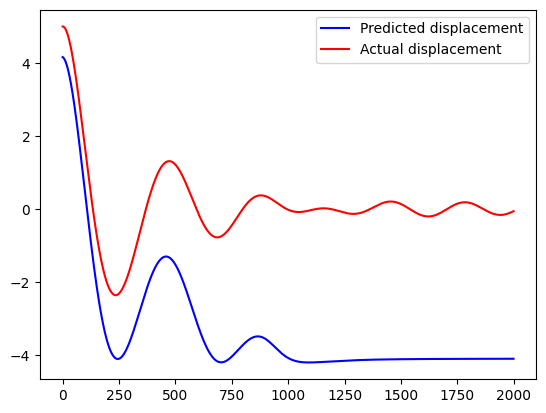

In [134]:
# [a.shape for a in samples]
# plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()
# plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
# plt.plot(t_train,x_train,'r',label='Actual displacement')
# plt.legend()
x_pred.shape
plt.plot(x_pred[9,:,0],'b',label='Predicted displacement')
plt.plot(x_train,'r',label='Actual displacement')
plt.legend()

In [103]:
x_pred.shape

(10, 2000, 1)

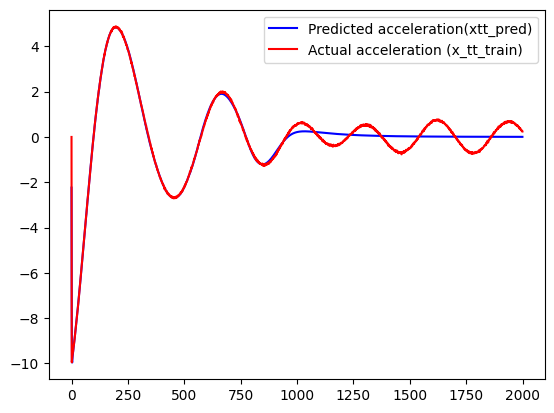

In [135]:
xtt_pred.shape
plt.plot(xtt_pred[0,9,:,9],'b',label='Predicted acceleration(xtt_pred)')
plt.plot(x_tt_train,'r',label='Actual acceleration (x_tt_train)')
plt.legend()

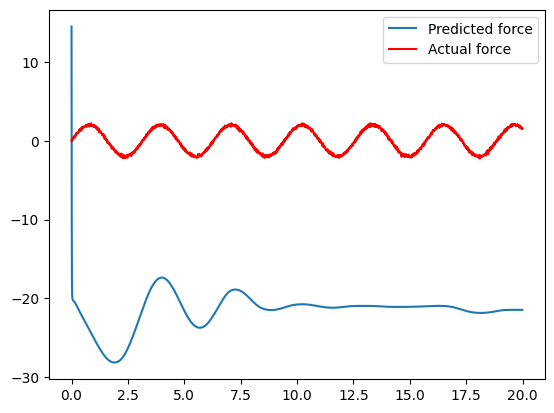

In [136]:
# (f_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)
plt.plot(t_train,np.mean(f_pred,axis=(0, 2)),label='Predicted force')
plt.plot(t_train,f_train,'r',label='Actual force')
plt.legend()

In [ ]:
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=pde_fn)
# f_pred.shape
# plt.plot(xtt_pred[0].flatten())
# plt.plot(x_tt_train)

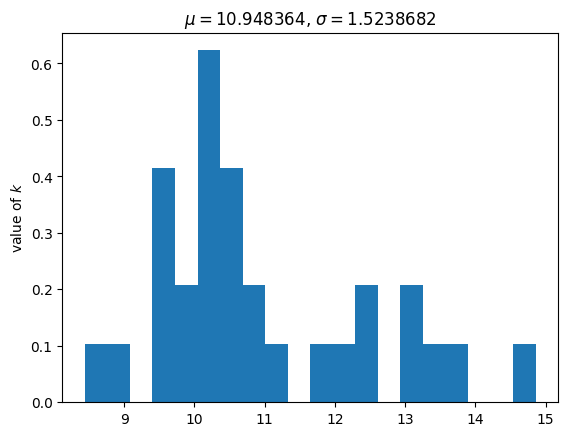

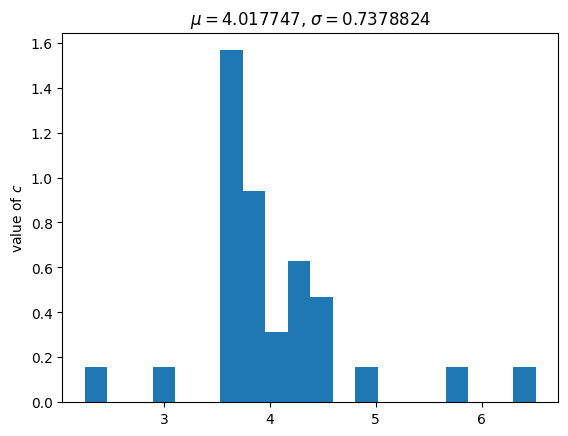

In [137]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [138]:
K_post=np.mean(np.exp(logk_pred))
print("K_true=10(N/m) and K_post =", K_post) 
C_post=np.mean(np.exp(logc_pred))
print("C_true=0.22(Ns/m) and C_post =", C_post) 

K_true=10(N/m) and K_post = 10.948364
C_true=0.22(Ns/m) and C_post = 4.017747
